In [86]:
import pandas as pd

import numpy as np
from numpy import unique

from scipy.special import expit as sigmoid

import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, Embedding, Flatten, Subtract, Concatenate
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split


In [155]:
games_tourney = pd.read_csv('basketball_data/games_tourney.csv')
print(games_tourney.info())
games_tourney_train = games_tourney[:3430]
games_tourney_test = games_tourney[3430:]
print(games_tourney_train.tail())
print(games_tourney_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 9 columns):
season        4234 non-null int64
team_1        4234 non-null int64
team_2        4234 non-null int64
home          4234 non-null int64
seed_diff     4234 non-null int64
score_diff    4234 non-null int64
score_1       4234 non-null int64
score_2       4234 non-null int64
won           4234 non-null int64
dtypes: int64(9)
memory usage: 297.8 KB
None
      season  team_1  team_2  home  seed_diff  score_diff  score_1  score_2  \
3425    2011     667   10690     0         -9         -14       58       72   
3426    2011    1039   10690     0         -4           7       61       54   
3427    2011    4209   10690     0         -1          -5       65       70   
3428    2011    1073   10713     0         11           8       74       66   
3429    2011    4899   10812     0         -5          11       66       55   

      won  
3425    0  
3426    1  
3427    0  
3428    1  
3429    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
None


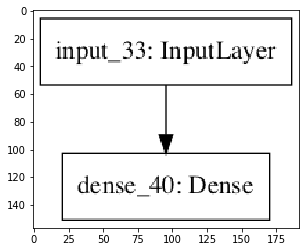

Train on 3087 samples, validate on 343 samples
Epoch 1/1
804/804 [==============================] - 0s 53us/step


14.188138662879147

In [156]:
input_tensor = Input(shape=(1,))
output_tensor = Dense(1)(input_tensor)
model1 = Model(input_tensor, output_tensor)
model1.compile(optimizer='adam', loss='mean_absolute_error')
print(model1.summary())
plot_model(model1, to_file='model1.png')
data = plt.imread('model1.png')
plt.imshow(data)
plt.show()
model1.fit(games_tourney_train.seed_diff, games_tourney_train.score_diff, 
          epochs=1, batch_size=128, validation_split=0.1, verbose=True)
model1.evaluate(games_tourney_test.seed_diff, games_tourney_test.score_diff)

In [157]:
games_season = pd.read_csv('basketball_data/games_season.csv')
print(games_season.head())
n_teams = unique(games_season.team_1).shape[0]
print(n_teams)

   season  team_1  team_2  home  score_diff  score_1  score_2  won
0    1985    3745    6664     0          17       81       64    1
1    1985     126    7493     1           7       77       70    1
2    1985     288    3593     1           7       63       56    1
3    1985    1846    9881     1          16       70       54    1
4    1985    2675   10298     1          12       86       74    1
10888


Train on 280960 samples, validate on 31218 samples
Epoch 1/10
280960/280960 [==============================] - 3s 11us/step - loss: 12.1201 - val_loss: 11.8383
Epoch 2/10
280960/280960 [==============================] - 1s 3us/step - loss: 12.0967 - val_loss: 11.8210
Epoch 3/10
280960/280960 [==============================] - 1s 3us/step - loss: 12.0733 - val_loss: 11.8037
Epoch 4/10
280960/280960 [==============================] - 1s 3us/step - loss: 12.0500 - val_loss: 11.7864
Epoch 5/10
280960/280960 [==============================] - 1s 3us/step - loss: 12.0268 - val_loss: 11.7690
Epoch 6/10
280960/280960 [==============================] - 1s 4us/step - loss: 12.0035 - val_loss: 11.7518
Epoch 7/10
280960/280960 [==============================] - 1s 3us/step - loss: 11.9802 - val_loss: 11.7345
Epoch 8/10
280960/280960 [==============================] - 1s 3us/step - loss: 11.9569 - val_loss: 11.7172
Epoch 9/10
280960/280960 [==============================] - 1s 3us/step - loss: 11.9

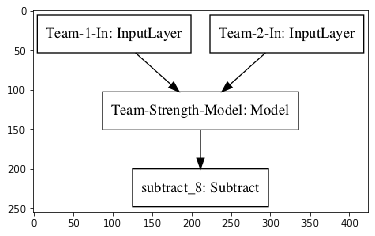

In [158]:
team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, 
                        name='Team-Strength')
teamid_in = Input(shape=(1, ))
strength_lookup = team_lookup(teamid_in)
strength_lookup_flat = Flatten()(strength_lookup)
team_strength_model = Model(teamid_in, strength_lookup_flat, 
                            name='Team-Strength-Model')
team_in_1 = Input(shape=(1, ), name='Team-1-In')
team_in_2 = Input(shape=(1, ), name='Team-2-In')
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)
score_diff = Subtract()([team_1_strength, team_2_strength])
model2 = Model([team_in_1, team_in_2], score_diff)
model2.compile('adam', 'mean_absolute_error')
input_1 = games_season.team_1
input_2 = games_season.team_2
model2.fit([input_1, input_2], games_season.score_diff, epochs=10, batch_size=2048,
          validation_split=0.1, verbose=True)
input_1 = games_tourney.team_1
input_2 = games_tourney.team_2
model2.evaluate([input_1, input_2], games_tourney.score_diff)
plot_model(model2, to_file='model2.png')
data = plt.imread('model2.png')
plt.imshow(data)
plt.show()

Train on 280960 samples, validate on 31218 samples
Epoch 1/10
280960/280960 [==============================] - 4s 15us/step - loss: 12.1024 - val_loss: 11.7191
Epoch 2/10
280960/280960 [==============================] - 2s 6us/step - loss: 12.0179 - val_loss: 11.8856
Epoch 3/10
280960/280960 [==============================] - 2s 6us/step - loss: 11.9233 - val_loss: 12.0408
Epoch 4/10
280960/280960 [==============================] - 2s 5us/step - loss: 11.8197 - val_loss: 12.1810
Epoch 5/10
280960/280960 [==============================] - 2s 5us/step - loss: 11.7090 - val_loss: 12.3015
Epoch 6/10
280960/280960 [==============================] - 2s 5us/step - loss: 11.5925 - val_loss: 12.4038
Epoch 7/10
280960/280960 [==============================] - 2s 6us/step - loss: 11.4713 - val_loss: 12.4832
Epoch 8/10
280960/280960 [==============================] - 2s 6us/step - loss: 11.3464 - val_loss: 12.5403
Epoch 9/10
280960/280960 [==============================] - 2s 6us/step - loss: 11.2

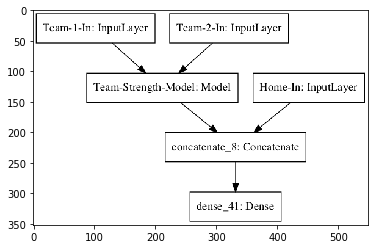

In [159]:
team_in_1 = Input(shape=(1, ), name='Team-1-In')
team_in_2 = Input(shape=(1, ), name='Team-2-In')
home_in = Input(shape=(1, ), name='Home-In')
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)
model3 = Model([team_in_1, team_in_2, home_in], out)
model3.compile(optimizer='adam', loss='mean_absolute_error')
model3.fit([games_season.team_1, games_season.team_2, games_season.home],
          games_season.score_diff, epochs=10, verbose=True, validation_split=0.1,
          batch_size=2048)
model3.evaluate([games_tourney.team_1, games_tourney.team_2, games_tourney.home],
               games_tourney.score_diff)
print(model3.summary())
plot_model(model3, to_file='model3.png')
data = plt.imread('model3.png')
plt.imshow(data)
plt.show()

Epoch 1/10
3168/3168 [==============================] - 2s 726us/step - loss: 9.4479
Epoch 2/10
3168/3168 [==============================] - 0s 62us/step - loss: 9.3524
Epoch 3/10
3168/3168 [==============================] - 0s 64us/step - loss: 9.2811
Epoch 4/10
3168/3168 [==============================] - 0s 62us/step - loss: 9.2309
Epoch 5/10
3168/3168 [==============================] - 0s 68us/step - loss: 9.1952
Epoch 6/10
3168/3168 [==============================] - 0s 63us/step - loss: 9.1693
Epoch 7/10
3168/3168 [==============================] - 0s 67us/step - loss: 9.1529
Epoch 8/10
3168/3168 [==============================] - 0s 95us/step - loss: 9.1417
Epoch 9/10
3168/3168 [==============================] - 0s 68us/step - loss: 9.1338
Epoch 10/10
1066/1066 [==============================] - 1s 711us/step


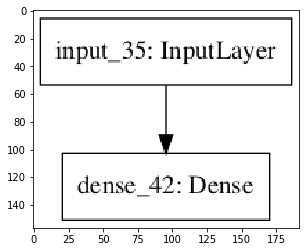

In [160]:
games_tourney['pred'] = model3.predict([games_tourney.team_1, games_tourney.team_2, \
                                       games_tourney.home])
input_tensor = Input((3, ))
output_tensor = Dense(1)(input_tensor)
model4 = Model(input_tensor, output_tensor)
model4.compile(optimizer='adam', loss='mean_absolute_error')
games_tourney_train = games_tourney[:3168]
model4.fit(games_tourney_train[['home', 'seed_diff', 'pred']], 
           games_tourney_train.score_diff, epochs=10, verbose=True)
games_tourney_test = games_tourney[3168:]
model4.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']],
               games_tourney_test.score_diff)
plot_model(model4, to_file='model4.png')
data = plt.imread('model4.png')
plt.imshow(data)
plt.show()

Epoch 1/10
3168/3168 [==============================] - 2s 745us/step - loss: 72.7259
Epoch 2/10
3168/3168 [==============================] - 0s 2us/step - loss: 72.7240
Epoch 3/10
3168/3168 [==============================] - 0s 5us/step - loss: 72.7215
Epoch 4/10
3168/3168 [==============================] - 0s 5us/step - loss: 72.7192
Epoch 5/10
3168/3168 [==============================] - 0s 4us/step - loss: 72.7167
Epoch 6/10
3168/3168 [==============================] - 0s 4us/step - loss: 72.7143
Epoch 7/10
3168/3168 [==============================] - 0s 5us/step - loss: 72.7118
Epoch 8/10
3168/3168 [==============================] - 0s 5us/step - loss: 72.7093
Epoch 9/10
3168/3168 [==============================] - 0s 5us/step - loss: 72.7067
Epoch 10/10
3168/3168 [==============================] - 0s 6us/step - loss: 72.7042
[array([[-0.3858854 ,  1.1541948 ],
       [-0.41200235, -0.6369628 ]], dtype=float32), array([0.00957607, 0.00957607], dtype=float32)]
season        1997.04

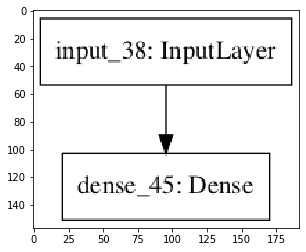

In [163]:
input_tensor = Input(shape=(2, ))
output_tensor = Dense(2)(input_tensor)
model5 = Model(input_tensor, output_tensor)
model5.compile(optimizer='adam', loss='mean_absolute_error')
model5.fit(games_tourney_train[['seed_diff', 'pred']], 
          games_tourney_train[['score_1', 'score_2']], 
          verbose=True, epochs=10, batch_size=16384)
print(model5.get_weights())
print(games_tourney_train.mean())
model5.evaluate(games_tourney_test[['seed_diff', 'pred']], 
               games_tourney_test[['score_1', 'score_2']])
plot_model(model5, to_file='model5.png')
data = plt.imread('model5.png')
plt.imshow(data)
plt.show()

In [139]:
input_tensor = Input(shape=(2, ))
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)
model = Model(input_tensor, [output_tensor_1, output_tensor_2])
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], 
              optimizer=Adam(0.01))
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=10, verbose=True, batch_size=16384)
print(model.get_weights())
print(games_tourney_train.mean())
weight = 0.14
print(sigmoid(weight))
print(sigmoid(10*weight))
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               [games_tourney_test[['score_diff']], games_tourney_test[['won']]])

Epoch 1/10
3168/3168 [==============================] - 2s 647us/step - loss: 17.7384 - dense_33_loss: 9.1994 - dense_34_loss: 8.5390
Epoch 2/10
3168/3168 [==============================] - 0s 4us/step - loss: 17.7121 - dense_33_loss: 9.1945 - dense_34_loss: 8.5176
Epoch 3/10
3168/3168 [==============================] - 0s 5us/step - loss: 17.6597 - dense_33_loss: 9.1884 - dense_34_loss: 8.4713
Epoch 4/10
3168/3168 [==============================] - 0s 7us/step - loss: 17.6115 - dense_33_loss: 9.1825 - dense_34_loss: 8.4290
Epoch 5/10
3168/3168 [==============================] - 0s 6us/step - loss: 17.5656 - dense_33_loss: 9.1775 - dense_34_loss: 8.3882
Epoch 6/10
3168/3168 [==============================] - 0s 7us/step - loss: 17.5181 - dense_33_loss: 9.1725 - dense_34_loss: 8.3456
Epoch 7/10
3168/3168 [==============================] - 0s 5us/step - loss: 17.4725 - dense_33_loss: 9.1688 - dense_34_loss: 8.3037
Epoch 8/10
3168/3168 [==============================] - 0s 4us/step - loss

[16.715229317126532, 9.178218735986535, 7.537010595454061]